# Traffic Signal Control Using Decentralised MARL via Graph

This Colab will help demonstrate the overall process using decentralised graph-transformer based model (**Our Best Model**):
* setting up the traffic system environment
* generating the graph representation of the traffic system
* a quick overview of the policy model
* measuring effectiveness of the decentralized graph-transformer based model.


## Prerequisites

Install necessary modules, libraries, and setting environment variables.

In [ ]:
!sudo add-apt-repository --yes ppa:sumo/stable
!sudo apt-get update
!sudo apt-get install sumo sumo-tools sumo-doc
!pip install traci
!pip install torch_geometric networkx

Repository: 'deb https://ppa.launchpadcontent.net/sumo/stable/ubuntu/ jammy main'
Description:
SUMO is a highly portable, microscopic traffic simulation package designed to handle large road networks. SUMO is open source, licensed under the EPLv2.
More info: https://launchpad.net/~sumo/+archive/ubuntu/stable
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/sumo-ubuntu-stable-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/sumo-ubuntu-stable-jammy.list
Adding key to /etc/apt/trusted.gpg.d/sumo-ubuntu-stable.gpg with fingerprint 7604B28616B7E70EC0E6D840C32412BB1ADB414B
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://arch

In [ ]:
#Declare the environment variable, SUMO_HOME
import os
os.environ['SUMO_HOME'] = "/usr/share/sumo"

In [ ]:
# check SUMO
!sumo

Eclipse SUMO sumo Version 1.21.0
 Build features: Linux-6.8.0-45-generic x86_64 GNU 11.4.0 Release FMI Proj GUI Intl SWIG Eigen GDAL GL2PS
 Copyright (C) 2001-2024 German Aerospace Center (DLR) and others; https://sumo.dlr.de
 License EPL-2.0: Eclipse Public License Version 2 <https://eclipse.org/legal/epl-v20.html>
 Use --help to get the list of options.


In [ ]:
# Import project github repository
!git clone --recursive https://github.com/EEEEEclectic/traffic_signal_control.git
%cd traffic_signal_control

Cloning into 'traffic_signal_control'...
remote: Enumerating objects: 594, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 594 (delta 96), reused 0 (delta 0), pack-reused 446 (from 1)
Receiving objects: 100% (594/594), 2.67 MiB | 6.07 MiB/s, done.
Resolving deltas: 100% (264/264), done.
/content/traffic_signal_control


In [ ]:
!export LIBSUMO_AS_TRACI=1
!pip install -e .

Obtaining file:///content/traffic_signal_control
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 39.4 MB/s eta 0:00:00
  Building editable for sumo-rl (pyproject.toml) ... done
  Created wheel for sumo-rl: filename=sumo_rl-1.4.5-0.editable-py3-none-any.whl size=7601 sha256=19e250a285d89bea74a71a59528221620f0002ced803b4eb2c4fce6c43a79ebb
  Stored in directory: /tmp/pip-ephem-wheel-cache-qqcedpdz/wheels/34/0f/77/69693e102b023661fc4fc35eb6c0cb5ed67eacbcbad96b5f42
Successfully built sumo-rl


In [3]:
import sumo_rl
from sumo_rl.models.util import *
from sumo_rl.agents.pg_multi_agent import PGMultiAgent
from sumo_rl.models.transformer_model import PolicyNetwork
import torch

## Create Traffic System Environment

In [4]:
# Set network file, route file, and output csv
NET_FILE = './sumo_rl/nets/RESCO/grid4x4/grid4x4.net.xml'
ROUTE_FILE = './sumo_rl/nets/RESCO/grid4x4/grid4x4_1.rou.xml'
OUTPUT_CSV = './results/my_result'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# Initialise the training environment
train_env = sumo_rl.parallel_env(
    net_file=NET_FILE,
    route_file=ROUTE_FILE,
    out_csv_name=OUTPUT_CSV,
    use_gui=False,
    num_seconds=3000,
    begin_time=100,
    fixed_ts=True,
    reward_fn="weighted_wait_queue"  # r_i,t = queue_i,t + gamma * wait_i,t
)

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 51ms, vehicles TOT 0 ACT 0 BUF 0)                     


### Create Graph Representation of Traffic System

For graph representation of the traffic system, we ascribe each traffic signal in the traffic system as a node, and each lane as a directed edge connecting two nodes. We also include the incoming/outgoing virtual nodes in the graph.

Within the traffic system, there are multiple lanes between two traffic signals, making it possible to create a Multi-Directed graph.

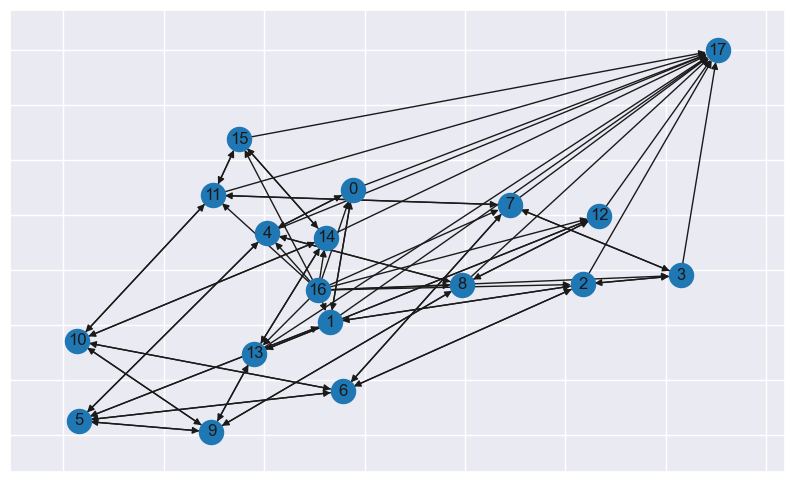

In [6]:
# transformer
# Build graph representation
traffic_signals = [ts for _, ts in train_env.aec_env.env.env.env.traffic_signals.items()]
max_lanes = max(len(ts.lanes) for ts in traffic_signals)  # max incoming lanes
max_green_phases = max(ts.num_green_phases for ts in traffic_signals)
ts_phases = [ts.num_green_phases for ts in traffic_signals]
feature_size = 2*max_lanes # density + queue
hid_dim = 128
num_virtual_nodes = 2  # incoming/outgoing

ts_indx, num_nodes, lanes_index, adj_list, incoming_lane_ts, outgoing_lane_ts = (
    construct_graph_representation(traffic_signals)) # adj_list: np.array [|E|, 2]
action_mask = create_action_mask(num_nodes, max_green_phases, ts_phases)

G = build_networkx_G(adj_list)  # creates an undirected graph
laplacian_matrix, eigenvals, eigenvecs = get_laplacian_eigenvecs(G)
edge_index = torch.tensor(adj_list.T, dtype=torch.long, device=DEVICE)  # [2, |E|]

nx.draw_networkx(G, arrows=True, with_labels=True)

### Experiment

In this experiment, we iterate over `num_episodes` using a graph-based policy model. During each epoch, each agent dynamically generates its local graph, incorporating the last k observations in real-time. Each agent operates with its own independent model, facilitating decentralized learning.

The model consists of two key components:
1. A recurrent module to capture temporal correlations.
2. A graph transformer to capture spatial correlations.

We track performance metrics at both the agent and system levels at each step of every episode for comprehensive performance assessment. The policy gradient method serves as the learning algorithm for this experiment.


In [ ]:
k = 5
hops = 2
MODEL_DIR = "./models"

# transformer
model_args = {
    "laplacian_matrix": laplacian_matrix,
    "eigenvals": eigenvals,
    "eigenvecs": eigenvecs,
    "ts_indx": ts_indx,
    "in_features": feature_size,
    "output_features": max_green_phases,
    # Network hyperparameters
    "num_transformer_layers": 2,
    "num_proj_layers": 2,
    "hidden_features": hid_dim,
    "action_mask": action_mask
}


PGMultiAgent = PGMultiAgent(ts_indx, edge_index, num_nodes, k, hops, model_args, DEVICE, models=None)
PGMultiAgent.train(train_env, num_episodes=100, model_dir=MODEL_DIR)

### Metrics

In addition to the decentralized graph-transformer-based model, we implemented centralized and decentralized DCRNN models as well. The comparisons of system-level metrics across these models are presented below.


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
import seaborn as sns
import os
import numpy as np

sns.set(
    style="darkgrid",
    rc={
        "figure.figsize": (10, 6),
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "lines.linewidth": 2,
    },
)

def moving_average(data, window_size):
    """Compute moving average."""
    if window_size == 1:
        return data
    return np.convolve(data, np.ones(window_size) / window_size, mode="same")


def compare_algorithms_final_episode(system_metrics, data_paths, algos, output_dir=None, ma=1):
    """
    Compare system-level metrics for the final episode across multiple algorithms.

    Args:
        system_metrics (list): List of system-level metrics to compare.
        data_paths (list): List of files
        algos (list): List of algorithms to compare.
        output_dir (str): Directory to save the comparison plots. If None, plots are only displayed.
    """
    final_episodes_data = []

    # Load the final episode data for each algorithm
    for data, algo in zip(data_paths, algos): # data_paths = ["results/my_result_conn0_ep200.csv"]
        df = pd.read_csv(data, sep=",")
        df["algorithm"] = algo  # Add algorithm name for labeling
        final_episodes_data.append(df)

    # Combine all final episode data
    data = pd.concat(final_episodes_data, ignore_index=True)

    # Plot each system metric
    for metric in system_metrics:
        plt.figure(figsize=(10, 6))
        line_styles = cycle(["-", "--", "-.", ":"])
        colors = cycle(sns.color_palette("colorblind", len(algorithm_names)))

        for algo_name in algos:
            algo_data = data[data["algorithm"] == algo_name]
            x = algo_data["step"].values
            y = algo_data[metric].values
            if ma > 1:
                y = moving_average(y, ma)
            plt.plot(x, y, label=f"{algo_name}", linestyle=next(line_styles), color=next(colors))

        plt.title(f"Comparison of {metric.replace('_', ' ').capitalize()} (Final Episode)")
        plt.xlabel("Timesteps")
        plt.ylabel(metric.replace("_", " ").capitalize())
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

        # Save or show the plot
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            save_path = os.path.join(output_dir, f"comparison_{metric}.pdf")
            plt.savefig(save_path, bbox_inches="tight")
        plt.show()

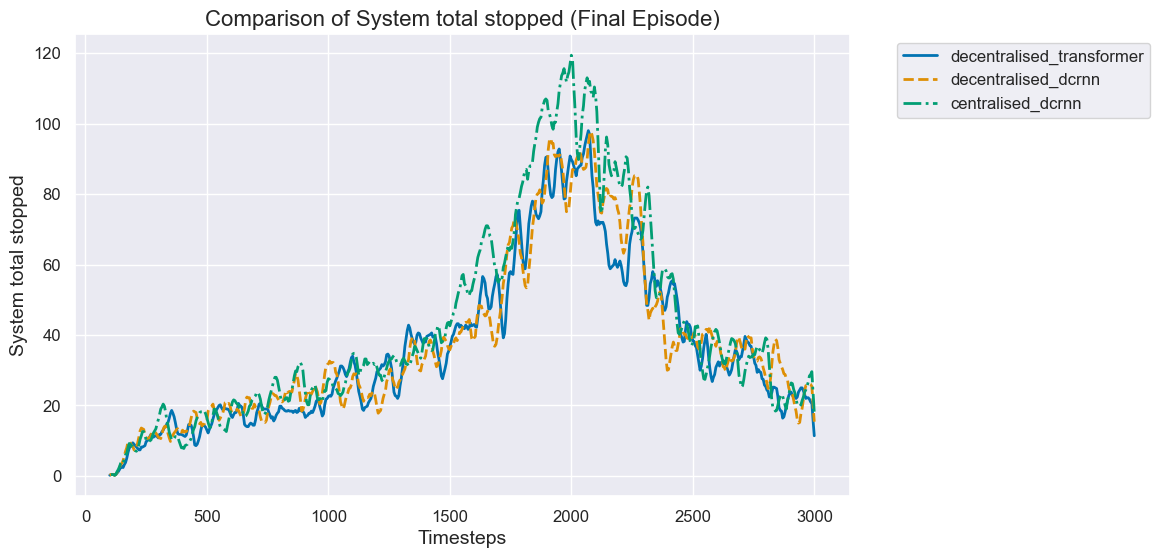

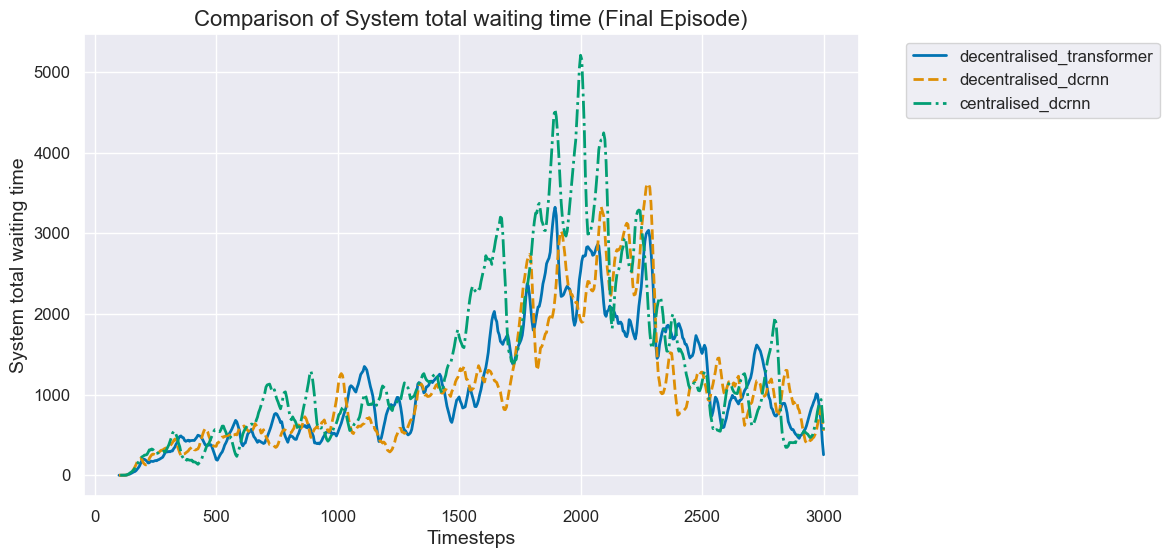

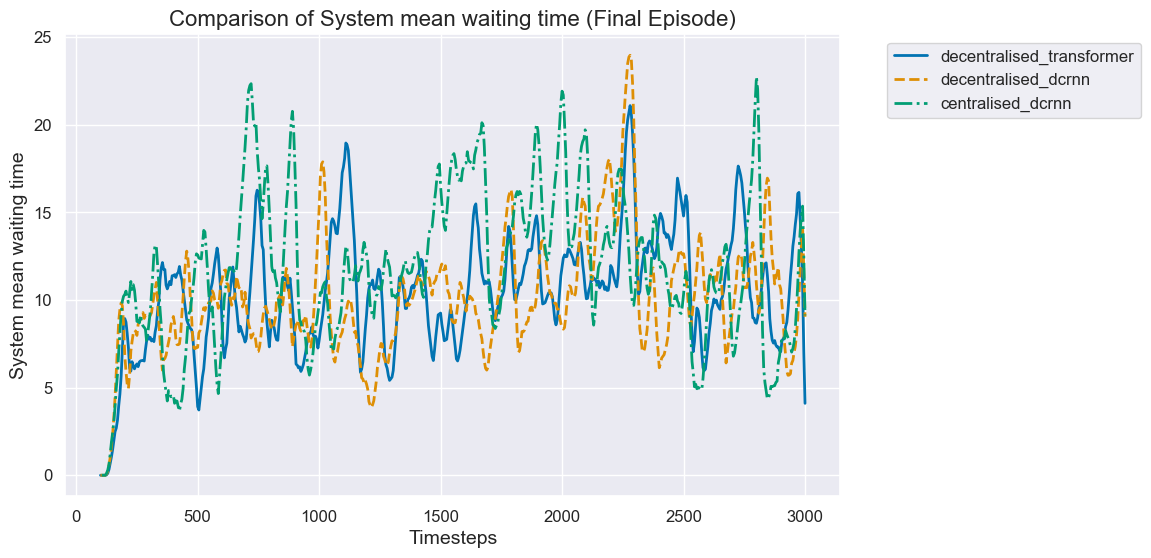

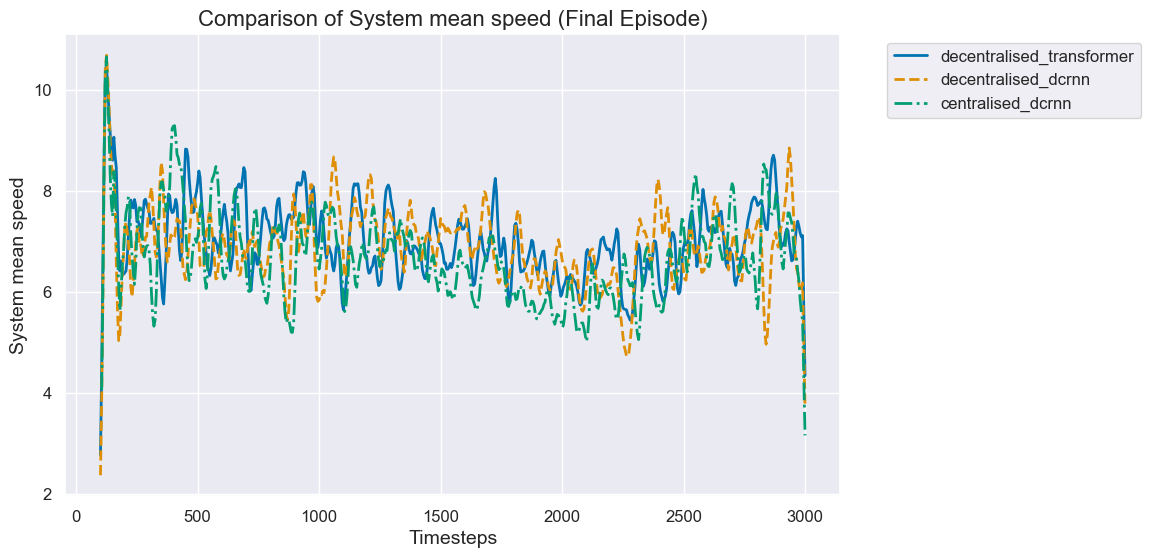

In [8]:
data_paths = [
        "results/my_result_conn0_ep200.csv",
        "results/my_result_dcrnn_conn0_ep100.csv",
        "results/train_result_conn0_ep50.csv",
    ]
algorithm_names = ["decentralised_transformer", "decentralised_dcrnn", "centralised_dcrnn"]
system_metrics = ["system_total_stopped","system_total_waiting_time","system_mean_waiting_time","system_mean_speed"]
output_dir = "outputs"
ma = 5

compare_algorithms_final_episode(system_metrics, data_paths, algorithm_names, output_dir, ma)